# Center Laneline Detection

## Abstract

In this notebook, we perform Laneline Detection by fine tuning pre-trained SOTA deep learning models such as ResNet backbone CNN model and Vision Transformer Model on the OpenLaneV2 dataset. Identifying the lanelines is essential for many downstream tasks like Motion Planning, 3D Occupancy Detection etc. in Autonomous Driving. 

## Dataset Description

The OpenLane dataset consists of multi-view images taken by cameras mounted on an ego vehicle. The dataset provides annotations for Lane lines, Traffic elements,Area elements(Pedestrian Crossing, Sidewalk etc)

Dataset Link - [here](https://github.com/OpenDriveLab/OpenLane-V2/blob/master/data/README.md#download)

## Setup 

In [1]:
!pip install torch torchvision transformers 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset
import os
import sys
import cv2
import numpy as np

In [3]:
import pandas as pd

data_dict_subset_A = pd.read_pickle('/work/cvpr/repo/OpenLane-V2/data/OpenLane-V2/data_dict_subset_A.pkl')

In [4]:
data_dict_train = {}
data_dict_val = {}

for i in data_dict_subset_A.keys():
    if i[0] == 'train':
        data_dict_train[i] = data_dict_subset_A[i]
    if i[0] == 'val':
        data_dict_val[i] = data_dict_subset_A[i]
    

In [105]:
data_dict_train[('train', '00000', '315967376899927209')]

{'version': 'OpenLaneV2_V2.0',
 'segment_id': '00000',
 'meta_data': {'source': 'ArgoverseV2',
  'source_id': '00a6ffc1-6ce9-3bc3-a060-6006e9893a1a'},
 'timestamp': 315967376899927209,
 'sensor': {'ring_front_center': {'image_path': 'train/00000/image/ring_front_center/315967376899927209.jpg',
   'extrinsic': {'rotation': array([[-9.57540534e-04,  5.28159325e-03,  9.99985594e-01],
           [-9.99999076e-01, -9.69974438e-04, -9.52430359e-04],
           [ 9.64930115e-04, -9.99985582e-01,  5.28251716e-03]]),
    'translation': array([1.63685016, 0.00213953, 1.40590799])},
   'intrinsic': {'K': array([[1.77733411e+03, 0.00000000e+00, 7.78222656e+02],
           [0.00000000e+00, 1.77733411e+03, 1.01621350e+03],
           [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
    'distortion': array([-0.24358925, -0.20579766,  0.32205908])}},
  'ring_front_left': {'image_path': 'train/00000/image/ring_front_left/315967376887425437.jpg',
   'extrinsic': {'rotation': array([[ 0.70601219, -0.0

### Utility Functions

#### Project 3d world co-ordinates to 2d image co-ordinates

In [5]:
import numpy as np

THICKNESS = 4

COLOR_DEFAULT = (0, 0, 255)
COLOR_DICT = {
    0:  COLOR_DEFAULT,
    1:  (255, 0, 0),
    2:  (0, 255, 0),
    3:  (255, 255, 0),
    4:  (255, 0, 255),
    5:  (0, 128, 128),
    6:  (0, 128, 0),
    7:  (128, 0, 0),
    8:  (128, 0, 128),
    9:  (128, 128, 0),
    10: (0, 0, 128),
    11: (64, 64, 64),
    12: (192, 192, 192),
}


def interp_arc(points, t=1000):
    r'''
    Linearly interpolate equally-spaced points along a polyline, either in 2d or 3d.

    Parameters
    ----------
    points : List
        List of shape (N,2) or (N,3), representing 2d or 3d-coordinates.
    t : array_like
        Number of points that will be uniformly interpolated and returned.

    Returns
    -------
    array_like  
        Numpy array of shape (N,2) or (N,3)

    Notes
    -----
    Adapted from https://github.com/johnwlambert/argoverse2-api/blob/main/src/av2/geometry/interpolate.py#L120

    '''
    
    # filter consecutive points with same coordinate
    temp = []
    for point in points:
        point = point.tolist()
        if temp == [] or point != temp[-1]:
            temp.append(point)
    if len(temp) <= 1:
        return None
    points = np.array(temp, dtype=points.dtype)

    assert points.ndim == 2

    # the number of points on the curve itself
    n, _ = points.shape

    # equally spaced in arclength -- the number of points that will be uniformly interpolated
    eq_spaced_points = np.linspace(0, 1, t)

    # Compute the chordal arclength of each segment.
    # Compute differences between each x coord, to get the dx's
    # Do the same to get dy's. Then the hypotenuse length is computed as a norm.
    chordlen = np.linalg.norm(np.diff(points, axis=0), axis=1)  # type: ignore
    # Normalize the arclengths to a unit total
    chordlen = chordlen / np.sum(chordlen)
    # cumulative arclength

    cumarc = np.zeros(len(chordlen) + 1)
    cumarc[1:] = np.cumsum(chordlen)

    # which interval did each point fall in, in terms of eq_spaced_points? (bin index)
    tbins = np.digitize(eq_spaced_points, bins=cumarc).astype(int)  # type: ignore

    # #catch any problems at the ends
    tbins[np.where((tbins <= 0) | (eq_spaced_points <= 0))] = 1  # type: ignore
    tbins[np.where((tbins >= n) | (eq_spaced_points >= 1))] = n - 1

    s = np.divide((eq_spaced_points - cumarc[tbins - 1]), chordlen[tbins - 1])
    anchors = points[tbins - 1, :]
    # broadcast to scale each row of `points` by a different row of s
    offsets = (points[tbins, :] - points[tbins - 1, :]) * s.reshape(-1, 1)
    points_interp = anchors + offsets
#     print(f"points interp : {points_interp}")
    return points_interp



In [6]:
def _project(points, intrinsic, extrinsic):
    if points is None:
        return points
    
    points_in_cam_cor = np.linalg.pinv(np.array(extrinsic['rotation'])) \
        @ (points.T - np.array(extrinsic['translation']).reshape(3, -1))
    
#     print("points cam 1 : ", points_in_cam_cor)
    
    points_in_cam_cor = points_in_cam_cor[:, points_in_cam_cor[2, :] > 0]
#     print("points cam : ", points_in_cam_cor)
    
    if points_in_cam_cor.shape[1] > 1:
        points_on_image_cor = np.array(intrinsic['K']) @ points_in_cam_cor
        points_on_image_cor = points_on_image_cor / (points_on_image_cor[-1, :].reshape(1, -1))
        points_on_image_cor = points_on_image_cor[:2, :].T
    else:
        points_on_image_cor = None
#     print(" points_on_image_cor : ", points_on_image_cor)
    return points_on_image_cor

In [ ]:
def project_3D_2D(predicted_points_3d_list, annotations):
    lane_points_2d = []
    for pts, ann in zip(predicted_points_3d_list, annotations):
        lane_pts = []
        for p in pts:
            lane_pts.append(_project(interp_arc(np.array(p)), ann[1], ann[2]))
        lane_points_2d.append(lane_pts)
        
    return lane_points_2d

### Defining Custom Dataset Class

In this class, we define functions to perform pre-processing and setup the data for model training

In [7]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class Lane3DDataset(Dataset):
    def __init__(self, image_dir, data_dict, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(data_dict)

    def load_annotations(self, data_dict):
        annotations = []
        max_size = 0
        try:
            for ann in data_dict:
                frame = data_dict[ann]['sensor']['ring_front_center']# get centerline annotations
                image_name = frame['image_path']
                # camera properties
                intrinsics = frame['intrinsic']
                extrinsics = frame['extrinsic']
                lane_segment = data_dict[ann]['annotation']['lane_segment']
                centr_line = []
                
                # identify lane lines belonging to respective images
                for lane in lane_segment:
                    lane_id = lane['id']
                    lane_points_3d = lane['centerline']
                    lane_points_2d = _project(interp_arc(np.array(lane_points_3d)), frame['intrinsic'],frame['extrinsic'])
                
                    if type(lane_points_2d) == np.ndarray:
                        # rows_to_add = 41 - lane_points_3d.shape[0]
                        # if rows_to_add > 0:
                            # Pad the array with zeros (or any other value you prefer) at the bottom
                            # lane_points_3d = np.pad(lane_points_3d, ((0, rows_to_add), (0, 0)), mode='constant', constant_values=0)
                        # print("padding.....................")
                        # lane_points_3d = pad_or_truncate_lanes(self, lane_points_3d)
                            
                        centr_line.append(lane_points_3d)
                # create a list of image and annotations for training     
                annotations.append((image_name, intrinsics, extrinsics, centr_line))
                
                if max_size < len(centr_line):
                    max_size = len(centr_line)
                # print(f"len of annotations : {len(annotations)}")
                # print("max size : ", max_size)
            return annotations
        except:
            print(data_dict[ann].keys())
            
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name, intrinsics, extrinsics, lane_points_2d = self.annotations[idx]
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        lane_points_2d = torch.tensor(lane_points_2d, dtype=torch.float32)

        return image, intrinsics, extrinsics, lane_points_2d


In [12]:
def pad_lane_lines(lane_lines, max_num_lane_lines, num_points):
    batch_size = len(lane_lines)
    padded_lane_lines = torch.zeros((batch_size, max_num_lane_lines, num_points, 3))
    mask = torch.zeros((batch_size, max_num_lane_lines))
    for i, lanes in enumerate(lane_lines):
        num_lanes = len(lanes)
        padded_lane_lines[i, :num_lanes, :, :] = torch.tensor(lanes, dtype=torch.float32)
        mask[i, :num_lanes] = 1
    return padded_lane_lines, mask


In [117]:
def pad_lane_lines_vit(lane_lines, max_num_lane_lines, num_points):
    batch_size = len(lane_lines)
    padded_lane_lines = torch.zeros((batch_size, max_num_lane_lines, num_points, 3))
    mask = torch.zeros((batch_size, max_num_lane_lines))
    for i, lanes in enumerate(lane_lines):
        num_lanes = len(lanes)
        for j in range(num_lanes):
            if len(lanes[j]) > num_points:
                padded_lane_lines[i, j, :num_points, :] = torch.tensor(lanes[j][:num_points], dtype=torch.float32)
            else:
                padded_lane_lines[i, j, :len(lanes[j]), :] = torch.tensor(lanes[j], dtype=torch.float32)
        mask[i, :num_lanes] = 1
    return padded_lane_lines, mask


In [8]:
# Function to pad lane lines for consistency.
# The data loader expects each lane line annotation to have the same dimensions. 

def collate_fn(batch):
    images = []
    intrinsic = []
    extrinsic = []
    lane_points = []
    
    for item in batch:
        if len(item[3]) > 0:
            images.append(item[0])
            intrinsic.append(item[1])
            extrinsic.append(item[2])
            lane_points.append(item[3])
    
    # print(f"Lane points : {lane_points}")
    images = torch.stack(images)
    if len(lane_points) > 0:
        # Pad lane points
        max_num_lanes = max(len(lanes) for lanes in lane_points)
        max_num_points = max(max(len(lane) for lane in lanes) for lanes in lane_points if len(lanes) > 0)

        padded_lane_points = []
        for lanes in lane_points:
            padded_lanes = []
            for lane in lanes:
                lane = torch.tensor(lane, dtype=torch.float)
                # print(f"lane shape: {lane}")
                if lane.shape[0] < max_num_points:
                    padding = torch.zeros((max_num_points - lane.shape[0], 3))
                    lane = torch.cat((lane, padding), dim=0)
                padded_lanes.append(lane)
            if len(padded_lanes) < max_num_lanes:
                for _ in range(max_num_lanes - len(padded_lanes)):
                    padded_lanes.append(torch.zeros((max_num_points, 3)))
            padded_lane_points.append(torch.stack(padded_lanes))
        # print(len(padded_lane_points))
        padded_lane_points = torch.stack(padded_lane_points)

        return images, intrinsic, extrinsic, padded_lane_points
    else:
        return [], [], [], []


In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = Lane3DDataset(image_dir='/work/cvpr/repo/OpenLane-V2/data/OpenLane-V2/', data_dict=data_dict_train, transform=transform)


In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

### 3D Laneline Detection Model - ResNet Backbone

In [11]:
# Resnet 50
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)


In [11]:
class ResNet3DLaneDetection(nn.Module):
    def __init__(self, num_points, max_num_lane_lines):
        super(ResNet3DLaneDetection, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Remove the fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add a global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Add a fully connected layer to predict 3D lane points
        self.fc = nn.Linear(2048, max_num_lane_lines * num_points * 3)  

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x.view(x.size(0), max_num_lane_lines, num_points,3) 

# Number of points to detect per lane
# num_points = 10
# model = ResNet3DLaneDetection(num_points=num_points)


## Model Training

In [146]:
import torch.optim as optim

# params
num_points = 10 # 10 points(x,y,z) per laneline
max_num_lane_lines = 61 # 61 lanelines per image

# Model
model = ResNet3DLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)
model = model.cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    try:
        for images, intrinsic, extrinsic, lane_points_2d in dataloader:
            images = images.cuda()
            lane_points_2d = lane_points_2d.cuda()
            
            # Pad the lane lines
            padded_lane_lines, mask = pad_lane_lines(lane_points_2d, max_num_lane_lines, num_points)
            padded_lane_lines = padded_lane_lines.cuda()
            mask = mask.cuda()

            optimizer.zero_grad()
            outputs = model(images)# predictions
            
            # Compute loss
            loss = criterion(outputs, padded_lane_lines)
            loss = loss * mask.unsqueeze(-1).unsqueeze(-1)  
            loss = loss.mean()  

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")
    except:
        print("error")

# Save the trained model
torch.save(model.state_dict(), 'lane_detection_model.pth')


/home/kunigalharish.a/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kunigalharish.a/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_24607/3202377868.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lane = torch.tensor(lane, dtype=torch.float)


error
error
error
error
error
error
error
error
error
error


## Model Evaluation

In [17]:
val_dataset = Lane3DDataset(image_dir='/work/cvpr/repo/OpenLane-V2/data/OpenLane-V2/', data_dict=data_dict_val, transform=transform)

In [18]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [19]:
# Function to compute the difference between predicted and ground truth laneline points

def compute_offset(preds, gts):
    offset_list = []
    
    for i in range(len(preds)):
        offset_list.append(preds[i] - gts[i][3])
    return offset_list
        
# element_wise_off = compute_offset(predicted_points_2d_list, val_dataset.annotations)

In [15]:
# Load model for evaluation
num_points = 10
max_num_lane_lines = 61

model = ResNet3DLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)

model.load_state_dict(torch.load('lane_detection_model.pth'))
model = model.cuda()  

/home/kunigalharish.a/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kunigalharish.a/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Perform evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setup model for evaluation
model.eval()

# data for projecting 3d points to 2d for visualization
predicted_points_3d_list = []
intrinsic_list = []
extrinsic_list = []

total_loss = 0.0
num_batches = 0

with torch.no_grad():
    for images, intrinsic, extrinsic, lane_lines in val_dataloader:
        images = images.to(device)
        
        # Pad the lane lines to make it consistent
        padded_lane_lines, mask = pad_lane_lines(lane_lines, max_num_lane_lines, num_points)
        padded_lane_lines = padded_lane_lines.cuda()
        mask = mask.cuda()
        # lane_lines = lane_lines.to(device)
        
        # Forward pass
        outputs = model(images)
        # print(outputs)
        
        predicted_points_3d_list.append(outputs.cpu())
        intrinsic_list.append(intrinsic)
        extrinsic_list.append(extrinsic)
        
        # Compute the loss
        loss = criterion(outputs, padded_lane_lines)
        loss = loss * mask.unsqueeze(-1).unsqueeze(-1)  # Apply mask
        loss = loss.mean()  # Compute mean loss

        total_loss += loss.item()
        num_batches += 1

# Compute the average loss
average_loss = total_loss / num_batches
print(f"Validation Loss: {average_loss}")
        

/tmp/ipykernel_23917/593227333.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  lane_points_2d = torch.tensor(lane_points_2d, dtype=torch.float32)
/tmp/ipykernel_23917/1306975961.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lane = torch.tensor(lane, dtype=torch.float)
/tmp/ipykernel_23917/2078365369.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_lane_lines[i, :num_lanes, :, :] = torch.tensor(lanes, dtype=torch.float32)


Validation Loss: 39.35701541964002


In [22]:
# Flatten prediction list

points_3d = []

for pts in predicted_points_3d_list:
    for t in pts:
        points_3d.append(t)

In [231]:
# lane_points_2d = project_3D_2D(points_3d, val_dataset.annotations)

## Visualization

In [36]:
import matplotlib.pyplot as plt

# Function to draw lines on the image
def _draw_lane_centerline(image, points_list):
    
    colors = [COLOR_DEFAULT]
    # print(colors)
    for idx, color in enumerate(colors):
        for points in points_list:
            for i in range(len(points) - 1):
                x1 = int(points[i][0] + idx * THICKNESS * 1.5)
                y1 = int(points[i][1] + idx * THICKNESS * 1.5)
                x2 = int(points[i+1][0] + idx * THICKNESS * 1.5)
                y2 = int(points[i+1][1] + idx * THICKNESS * 1.5)

                # try:
                cv2.line(image, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=THICKNESS, lineType=cv2.LINE_AA)
                # print("annotation done")
                # except Exception:
                #     print("Annotation failed")
                #     return
    return image


In [86]:
def visualization(img_file, gt_list, preds_list):
    img_path = f"/work/cvpr/repo/OpenLane-V2/data/OpenLane-V2/{img_file}"
    # print(img_path)
    img_arr = cv2.imread(img_path)
    
    gt_img = _draw_lane_centerline(img_arr, gt_list)
    
    plt.figure(figsize=(12,8))
    
    plt.subplot(1, 2, 1)
    plt.title('Ground truth vs Predictions')
    plt.imshow(gt_img)
    
    img_arr = cv2.imread(img_path)
    pred_img = _draw_lane_centerline(img_arr, preds_list)

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    
    plt.show()
    

#### Ground Truth vs Predictions

In [92]:
# Sample Visualization 1

img_file = val_dataset.annotations[0][0]
gt_points = val_dataset.annotations[0][3]

# project 3d to 2d - ground truth
pts_2d_gt = []
for pt in gt_points:
    pts_ = _project(interp_arc(pt), val_dataset.annotations[0][1], val_dataset.annotations[0][2])
    if pts_ is not None:
        pts_2d_gt.append(pts_)
        
# project 3d to 2d - predictions

pts_2d_preds = []
for pt in range(points_3d[0].shape[0]):
    pts_ = _project(interp_arc(np.array(points_3d[0][pt])), val_dataset.annotations[0][1], val_dataset.annotations[0][2])
    if pts_ is not None:
        pts_2d_preds.append(pts_)

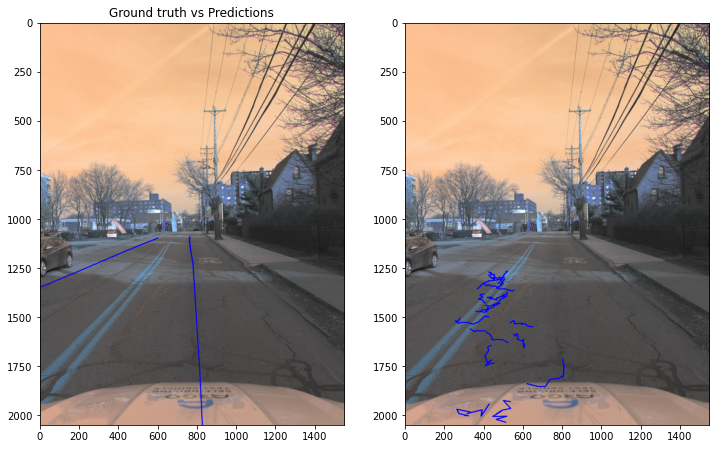

In [95]:
visualization(img_file, pts_2d_gt, pts_2d_preds)

In [96]:
# Sample Visualization 2

img_file = val_dataset.annotations[1][0]
gt_points = val_dataset.annotations[1][3]

# project 3d to 2d - ground truth
pts_2d_gt = []
for pt in gt_points:
    pts_ = _project(interp_arc(pt), val_dataset.annotations[1][1], val_dataset.annotations[1][2])
    if pts_ is not None:
        pts_2d_gt.append(pts_)

# project 3d to 2d - predictions

pts_2d_preds = []
for pt in range(points_3d[1].shape[0]):
    pts_ = _project(interp_arc(np.array(points_3d[1][pt])), val_dataset.annotations[1][1], val_dataset.annotations[1][2])
    if pts_ is not None:
        pts_2d_preds.append(pts_)

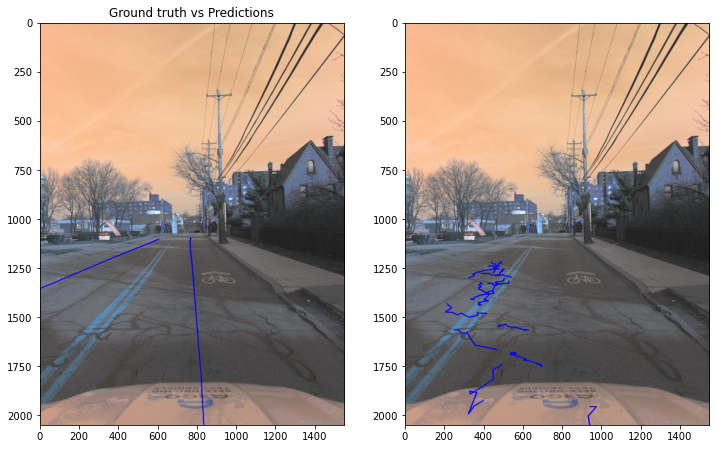

In [101]:
visualization(img_file, pts_2d_gt, pts_2d_preds)

In [113]:
# Sample Visualization 3

img_file = val_dataset.annotations[50][0]
gt_points = val_dataset.annotations[50][3]

# project 3d to 2d - ground truth
pts_2d_gt = []
for pt in gt_points:
    pts_ = _project(interp_arc(pt), val_dataset.annotations[50][1], val_dataset.annotations[50][2])
    if pts_ is not None:
        pts_2d_gt.append(pts_)
        
# project 3d to 2d - predictions

pts_2d_preds = []
for pt in range(points_3d[50].shape[0]):
    pts_ = _project(interp_arc(np.array(points_3d[50][pt])), val_dataset.annotations[50][1], val_dataset.annotations[50][2])
    if pts_ is not None:
        pts_2d_preds.append(pts_)


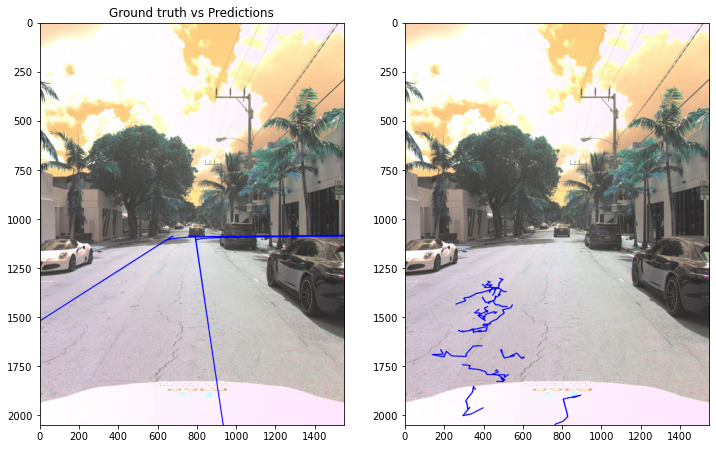

In [116]:
visualization(img_file, pts_2d_gt, pts_2d_preds)

## Lane Line Detection using Vision Transformer

We will use the pre-trained Vision Transformer and fine tuning it to predict 3d lane line points. 

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor


In [119]:
class ViTLaneDetection(nn.Module):
    def __init__(self, num_points, max_num_lane_lines):
        super(ViTLaneDetection, self).__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = ViTModel(config)
        self.fc = nn.Linear(config.hidden_size, max_num_lane_lines * num_points * 3)

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        x = outputs.last_hidden_state[:, 0]  # Use the [CLS] token
        x = self.fc(x)
        return x.view(x.size(0), max_num_lane_lines, num_points, 3)  # Reshape to (batch_size, max_num_lane_lines, num_points, 3)


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

num_points = 10
max_num_lane_lines = 61
model = ViTLaneDetection(num_points=num_points, max_num_lane_lines=max_num_lane_lines)
model = model.cuda()

# Loss and optimizer
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, intrinsic, extrinsic, lane_lines in dataloader:
        if images != [] or lane_lines != []:
            images = images.cuda()

            # Pad the lane lines and create a mask
            padded_lane_lines, mask = pad_lane_lines_vit(lane_lines, max_num_lane_lines, num_points)
            padded_lane_lines = padded_lane_lines.cuda()
            mask = mask.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, padded_lane_lines)
            loss = loss * mask.unsqueeze(-1).unsqueeze(-1)
            loss = loss.mean()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

    # Validation step
    model.eval()
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for images, intrinsic, extrinsic, lane_lines in val_dataloader:
            if images != [] or lane_lines != []:
                images = images.cuda()

                # Pad the lane lines and create a mask
                padded_lane_lines, mask = pad_lane_lines_vit(lane_lines, max_num_lane_lines, num_points)
                padded_lane_lines = padded_lane_lines.cuda()
                mask = mask.cuda()

                outputs = model(images)

                # Debugging: print shapes
                # print(f"Validation Output shape: {outputs.shape}, Padded Lane Lines shape: {padded_lane_lines.shape}")

                # Compute the loss
                loss = criterion(outputs, padded_lane_lines)
                loss = loss * mask.unsqueeze(-1).unsqueeze(-1)
                loss = loss.mean()

                total_loss += loss.item()
                num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Validation Loss: {average_loss}")

# Save the trained model
torch.save(model.state_dict(), 'vit_lane_detection_model.pth')


/tmp/ipykernel_23917/1306975961.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lane = torch.tensor(lane, dtype=torch.float)
/tmp/ipykernel_23917/75607491.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_lane_lines[i, j, :len(lanes[j]), :] = torch.tensor(lanes[j], dtype=torch.float32)
